In [22]:
import torch
from transformers import *

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


# Formatted Stimuli

Here, I'm assuming the general form of text-based stimuli is a list-of-list of tokens. Each list contains the stimuli in that 1.5 second window. For example:  

[  
"I have"],  
["a feeling"],  
["she went"]  
...]

In [46]:
stimulus = "I have a feeling she went to work on some bastard in the kitchen. I just have a feeling. She always starts necking some bastard in the kitchen"
single_word_tr_stimulus = stimulus.split()
single_word_tr_stimulus[:10]

['I', 'have', 'a', 'feeling', 'she', 'went', 'to', 'work', 'on', 'some']

In [248]:
span = 2
words = single_word_tr_stimulus
two_words_tr_stimulus = [" ".join(words[i:i+span]) for i in range(0, len(words), span)]
print(two_words_tr_stimulus[:10])

['I have', 'a feeling', 'she went', 'to work', 'on some', 'bastard in', 'the kitchen.', 'I just', 'have a', 'feeling. She']


# RSMs from BERT

#### Set up BERT model

In [48]:
bert_weights = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_weights)

# Models can return full list of hidden-states & attentions weights at each layer
bert = BertModel.from_pretrained(bert_weights,
                                 output_hidden_states=True,
                                 output_attentions=True)

### Input
Because BERT is bi-directional, we'll need to run it on each individual TR window, including some "lookback" window (e.g. something like the last minute of the story, so the preceeding 40 TRs). We'll do this by concatenating the stimulus for each successive TR and running that window through the model.

In [63]:
tr_lookback_window = 4
for i, tr in enumerate(two_words_tr_stimulus):
    
    window_start = max(0, i - tr_lookback_window)
    window_stimulus = " ".join(two_words_tr_stimulus[window_start:i+1])
    
    print("\"{}\" --> {}".format(tr, window_stimulus))

"I have" --> I have
"a feeling" --> I have a feeling
"she went" --> I have a feeling she went
"to work" --> I have a feeling she went to work
"on some" --> I have a feeling she went to work on some
"bastard in" --> a feeling she went to work on some bastard in
"the kitchen." --> she went to work on some bastard in the kitchen.
"I just" --> to work on some bastard in the kitchen. I just
"have a" --> on some bastard in the kitchen. I just have a
"feeling. She" --> bastard in the kitchen. I just have a feeling. She
"always starts" --> the kitchen. I just have a feeling. She always starts
"necking some" --> I just have a feeling. She always starts necking some
"bastard in" --> have a feeling. She always starts necking some bastard in
"the kitchen" --> feeling. She always starts necking some bastard in the kitchen


In [74]:
# Make sure we can tokenize and get the appropriate length back out.
for i, tr in enumerate(two_words_tr_stimulus[:12]):
    
    window_start = max(0, i - tr_lookback_window)
    window_stimulus = " ".join(two_words_tr_stimulus[window_start:i+1])
    window_tokens = bert_tokenizer.encode_plus(window_stimulus, return_tensors='pt', add_special_tokens=True)
    window_token_ids = window_tokens["input_ids"].numpy().tolist()
    
    tr_tokens = bert_tokenizer.encode_plus(tr, return_tensors='pt', add_special_tokens=False)
    tr_token_ids = tr_tokens["input_ids"].numpy().tolist()
    
    print("\"{}\": {} TR tokens, {} window tokens \n\tTR tokens: {} \n\tWindow tokens: {}\n".format(
        tr, len(tr_token_ids[0]), len(window_token_ids[0]), tr_token_ids[0], window_token_ids[0]))

"I have": 2 TR tokens, 4 window tokens 
	TR tokens: [1045, 2031] 
	Window tokens: [101, 1045, 2031, 102]

"a feeling": 2 TR tokens, 6 window tokens 
	TR tokens: [1037, 3110] 
	Window tokens: [101, 1045, 2031, 1037, 3110, 102]

"she went": 2 TR tokens, 8 window tokens 
	TR tokens: [2016, 2253] 
	Window tokens: [101, 1045, 2031, 1037, 3110, 2016, 2253, 102]

"to work": 2 TR tokens, 10 window tokens 
	TR tokens: [2000, 2147] 
	Window tokens: [101, 1045, 2031, 1037, 3110, 2016, 2253, 2000, 2147, 102]

"on some": 2 TR tokens, 12 window tokens 
	TR tokens: [2006, 2070] 
	Window tokens: [101, 1045, 2031, 1037, 3110, 2016, 2253, 2000, 2147, 2006, 2070, 102]

"bastard in": 2 TR tokens, 12 window tokens 
	TR tokens: [8444, 1999] 
	Window tokens: [101, 1037, 3110, 2016, 2253, 2000, 2147, 2006, 2070, 8444, 1999, 102]

"the kitchen.": 3 TR tokens, 13 window tokens 
	TR tokens: [1996, 3829, 1012] 
	Window tokens: [101, 2016, 2253, 2000, 2147, 2006, 2070, 8444, 1999, 1996, 3829, 1012, 102]

"I just":

### Output
We then need to summarize the BERT output over that window. We can start by averaging the BERT embeddings for the tokens that fell in that window.

First, we run BERT on the whole window stimulus and check output dimensions.

In [215]:
tr_activation_array = {}

# stimulus = single_word_tr_stimulus
stimulus = two_words_tr_stimulus

for i, tr in enumerate(stimulus):
    
    window_start = max(0, i - tr_lookback_window)
    window_stimulus = " ".join(stimulus[window_start:i+1])
    window_tokens = torch.tensor([bert_tokenizer.encode(window_stimulus, add_special_tokens=True)])
    
    tr_tokens = torch.tensor([bert_tokenizer.encode(tr, add_special_tokens=False)])[0]
    
    with torch.no_grad():

        bert_states, bert_attentions = bert(window_tokens)[-2:]
        
        # The "bert_states"/"bert_attentions" now contain activations for each (1) layer and (2) token.
        # They're first indexed layer-wise, i.e. bert_states is a tuple with one element per BERT layer.
        # So length = bert_layers + 1:
        print("\nLength of BERT states should be: n_layers + 1 --> {}".format(len(bert_states)))
        
        # Within each tuple, we'll have an embedding for each token. So let's look at a middle layer.
        print("Shape should be: [1, n_tokens, d_model] --> {}".format(bert_states[5].shape))
            
        # For each layer, we can access each token's embedding at:
        # bert_states[layer][0][token_index]
        # which will have dimensions = dim_model
        layer_5_token_2 = bert_states[5][0][1]
        print("Accessing embedding for layer 5, second token should be: d_model --> {}".format(len(layer_5_token_2)))
        
        # Finally, we can reach in and access the embeddings for this TR's stimulus.
        # These correspond to BERT's (contextualized) representations of this set of tokens.
        tr_activation_array[i] = {}
        for l, layer in enumerate(bert_states):
            tr_activations = layer[0][-(len(tr_tokens) + 1):-1]
            tr_activation_array[i][l] = tr_activations
            print("\tTokens for TR{}, Layer{}: {}/{} tokens.".format(i, l, len(tr_activations), len(tr_tokens)))


Length of BERT states should be: n_layers + 1 --> 13
Shape should be: [1, n_tokens, d_model] --> torch.Size([1, 4, 768])
Accessing embedding for layer 5, second token should be: d_model --> 768
	Tokens for TR0, Layer0: 2/2 tokens.
	Tokens for TR0, Layer1: 2/2 tokens.
	Tokens for TR0, Layer2: 2/2 tokens.
	Tokens for TR0, Layer3: 2/2 tokens.
	Tokens for TR0, Layer4: 2/2 tokens.
	Tokens for TR0, Layer5: 2/2 tokens.
	Tokens for TR0, Layer6: 2/2 tokens.
	Tokens for TR0, Layer7: 2/2 tokens.
	Tokens for TR0, Layer8: 2/2 tokens.
	Tokens for TR0, Layer9: 2/2 tokens.
	Tokens for TR0, Layer10: 2/2 tokens.
	Tokens for TR0, Layer11: 2/2 tokens.
	Tokens for TR0, Layer12: 2/2 tokens.

Length of BERT states should be: n_layers + 1 --> 13
Shape should be: [1, n_tokens, d_model] --> torch.Size([1, 6, 768])
Accessing embedding for layer 5, second token should be: d_model --> 768
	Tokens for TR1, Layer0: 2/2 tokens.
	Tokens for TR1, Layer1: 2/2 tokens.
	Tokens for TR1, Layer2: 2/2 tokens.
	Tokens for TR1

In [181]:
# tr_activation_array is now a list of lists of tensors. 
# The first index is "which TR"; the second index is "which layer"; the third is "which token".

# tr_activation_array[tr_index][layer_index][token_index]
print("We now have embeddings for {} TRs.".format(len(tr_activation_array)))

We now have embeddings for 14 TRs.


In [203]:
# Grab all activations from first layer.
layer_one_activations = [tr_activation_array[tr][1] for tr in tr_activation_array]
layer_one_averaged = []

# Average over all of the activations in this TR
for tr in layer_one_activations:
    average_stimulus = torch.mean(tr, 0)
    layer_one_averaged.append(average_stimulus)

### RSMs

Now that we have our full output, we need to get RSMs across the layers.

In [209]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [223]:
stacked = np.stack([l.numpy() for l in layer_one_averaged], axis=0)
layer_one_rsm = pd.DataFrame(np.corrcoef(stacked), columns=two_words_tr_stimulus, index=two_words_tr_stimulus)
layer_one_rsm

,I have,a feeling,she went,to work,on some,bastard in,the kitchen.,I just,have a,feeling. She,always starts,necking some,bastard in,the kitchen
I have,1.000000,0.352815,0.349393,0.304531,0.273174,0.261760,0.358270,0.534028,0.638158,0.408224,0.249171,0.278426,0.279597,0.293087
a feeling,0.352815,1.000000,0.339263,0.303425,0.312710,0.267949,0.300098,0.184899,0.465682,0.623256,0.182646,0.322082,0.255687,0.257660
she went,0.349393,0.339263,1.000000,0.359054,0.305556,0.267342,0.316652,0.284616,0.264904,0.507958,0.234484,0.316065,0.245228,0.265654
to work,0.304531,0.303425,0.359054,1.000000,0.418192,0.316186,0.390678,0.212958,0.335629,0.334167,0.230081,0.318134,0.254244,0.308804
on some,0.273174,0.312710,0.305556,0.418192,1.000000,0.387113,0.416699,0.297068,0.410772,0.354497,0.221394,0.563094,0.303180,0.309888
bastard in,0.261760,0.267949,0.267342,0.316186,0.387113,1.000000,0.433228,0.341656,0.372589,0.393510,0.148649,0.285338,0.912159,0.311680
the kitchen.,0.358270,0.300098,0.316652,0.390678,0.416699,0.433228,1.000000,0.372554,0.506231,0.544446,0.235772,0.335885,0.370434,0.880648
I just,0.534028,0.184899,0.284616,0.212958,0.297068,0.341656,0.372554,1.000000,0.428518,0.428188,0.362232,0.265466,0.332015,0.287314
have a,0.638158,0.465682,0.264904,0.335629,0.410772,0.372589,0.506231,0.428518,1.000000,0.450062,0.313346,0.375884,0.374566,0.422201
feeling. She,0.408224,0.623256,0.507958,0.334167,0.354497,0.393510,0.544446,0.428188,0.450062,1.000000,0.314684,0.396475,0.420663,0.408774


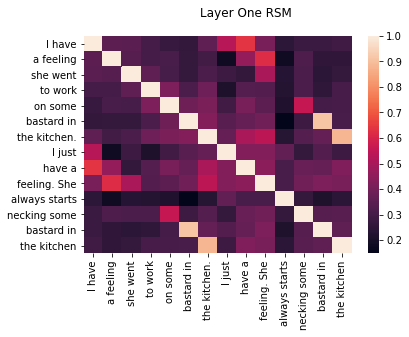

In [222]:
sns.heatmap(layer_one_rsm)
plt.suptitle("Layer One RSM");

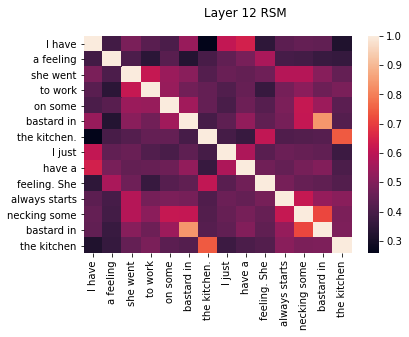

In [224]:
# Do the same for the last layer
last_layer_activations = [tr_activation_array[tr][12] for tr in tr_activation_array]
last_layer_averaged = []

for tr in last_layer_activations:
    average_stimulus = torch.mean(tr, 0)
    last_layer_averaged.append(average_stimulus)
    
stacked = np.stack([l.numpy() for l in last_layer_averaged], axis=0)
last_layer_rsm = pd.DataFrame(np.corrcoef(stacked), index=two_words_tr_stimulus, columns=two_words_tr_stimulus)
sns.heatmap(last_layer_rsm)
plt.suptitle("Layer 12 RSM");

In [243]:
def stimulus_to_rsm_dataframe(stimulus, tr_lookback_window):

    # Set this inside the loop based on whichever BERT model we're using
    num_bert_layers = 0;

    tr_activation_array = {}
    for i, tr in enumerate(stimulus):

        # Get the whole window we're going to 
        window_start = max(0, i - tr_lookback_window)
        window_stimulus = " ".join(stimulus[window_start:i+1])
        window_tokens = torch.tensor([bert_tokenizer.encode(window_stimulus, add_special_tokens=True)])

        tr_tokens = torch.tensor([bert_tokenizer.encode(tr, add_special_tokens=False)])[0]

        with torch.no_grad():

            tr_activation_array[i] = {}
            bert_states, bert_attentions = bert(window_tokens)[-2:]
            num_bert_layers = len(bert_states)

            for l, layer in enumerate(bert_states):

                # ASSUMPTION: we do not want to include the CLS/SEP token in the TR RSM.
                # If we do, switch indexing here to include last token.
                tr_activations = layer[0][-(len(tr_tokens) + 1):-1]

                # ASSUMPTION: take the mean of all tokens falling inside the TR stimuli window.
                tr_activation_array[i][l] = torch.mean(tr_activations, 0)

    # We now have the layers in a TR-based index: tr_activation_array[tr_index][layer_index]
    # To get a layer-wise RSM, we need to reverse this indexing. 
    layerwise_rsms = []
    for l in range(0, num_bert_layers):

        # Loop over our TR array and grab the target layer for each 
        layer_activations = [tr_activation_array[tr][l] for tr in tr_activation_array]
        stacked = np.stack([l.numpy() for l in layer_activations], axis=0)
        rsm_dataframe = pd.DataFrame(np.corrcoef(stacked), index=stimulus, columns=stimulus)

        layerwise_rsms.append(rsm_dataframe)
    
    return layerwise_rsms

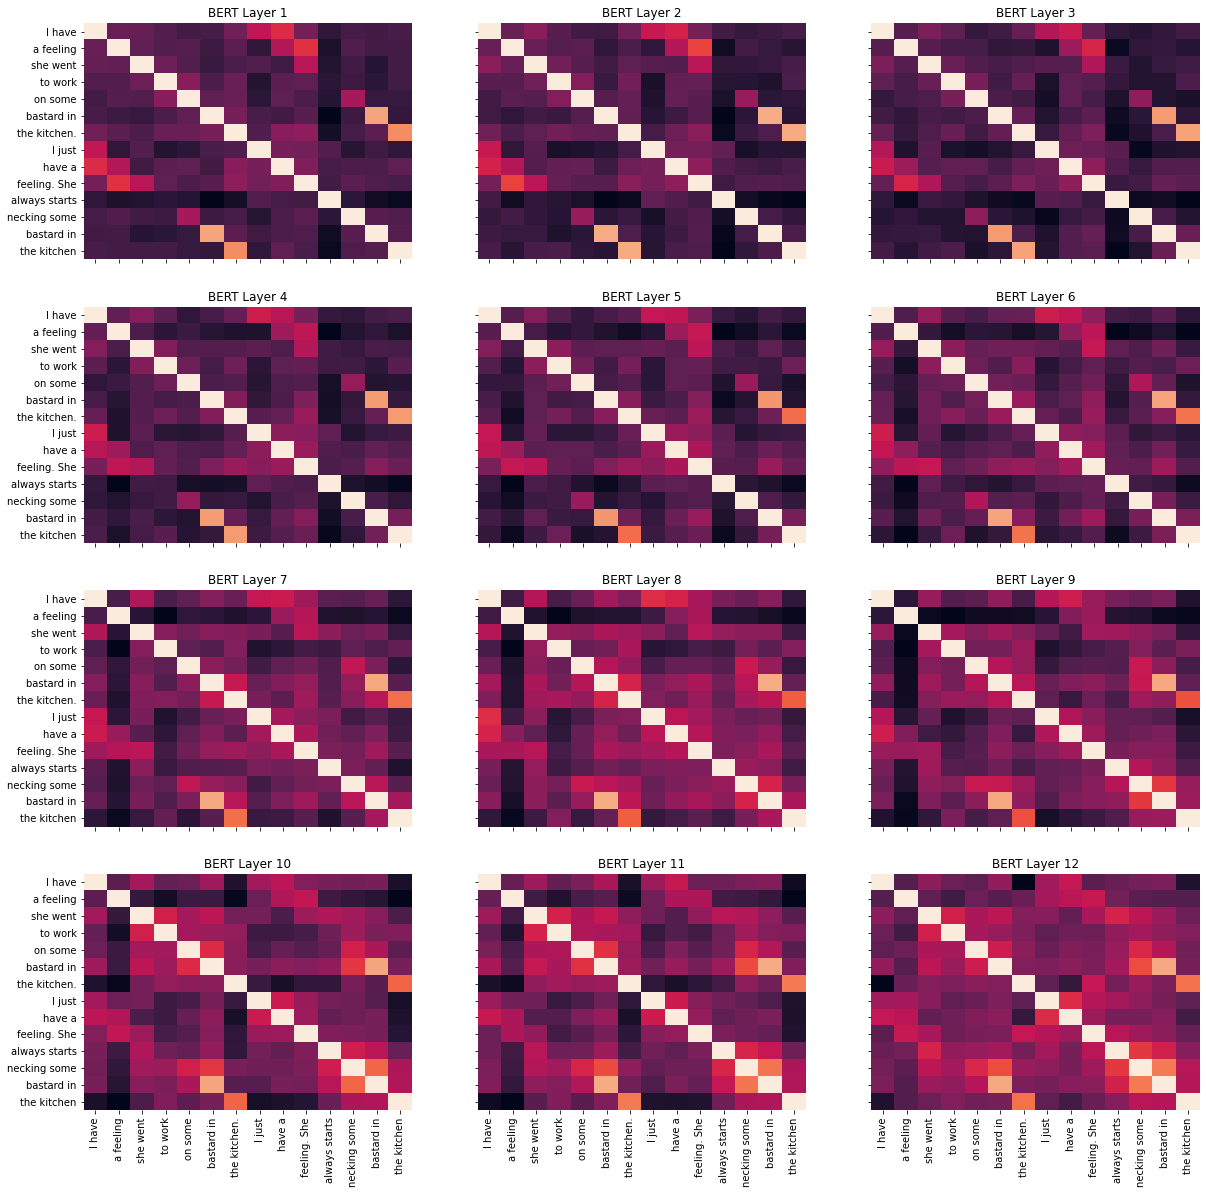

In [244]:
demo_string_rsms = stimulus_to_rsm_dataframe(two_words_tr_stimulus, 20)

fig, axs = plt.subplots(4, 3, figsize=(20,20),sharex=True, sharey=True)

# Reshape so we can index into subplots linearly
axs = axs.reshape(-1)

for i, rsm in enumerate(demo_string_rsms[1:]):
    sns.heatmap(rsm, ax=axs[i], cbar=False)
    axs[i].set_title("BERT Layer {}".format(i+1))

## Demo RSMs

Try generating a set of RSMs for a full text.

According to Sam, the story has about 460 TRs. When we split on whitespace, we get 900 tokens. Which naturally leads us to a first-pass of assuming that every two words goes into a different TR.

In [256]:
data = open("data/greeneyes.txt").read()

# If you want to print the whole story....
# print(data)

In [257]:
span = 2
whitespace_split = data.split()

full_story_bigram_trs = [" ".join(whitespace_split[i:i+span]) for i in range(0, len(whitespace_split), span)]
print(full_story_bigram_trs[:5])

['“All right,', 'try to', 'take it', 'a little', 'easy now,']


In [258]:
rsm_dfs = stimulus_to_rsm_dataframe(full_story_bigram_trs, 20)

In [259]:
for i, df in enumerate(rsm_dfs):
    df.to_csv("data/greeneyes-bert-rsms/layer_{}_rsm".format(i), header=False, index=False)

13

Text(0.5, 0.98, 'BERT Layer 0 RSM')

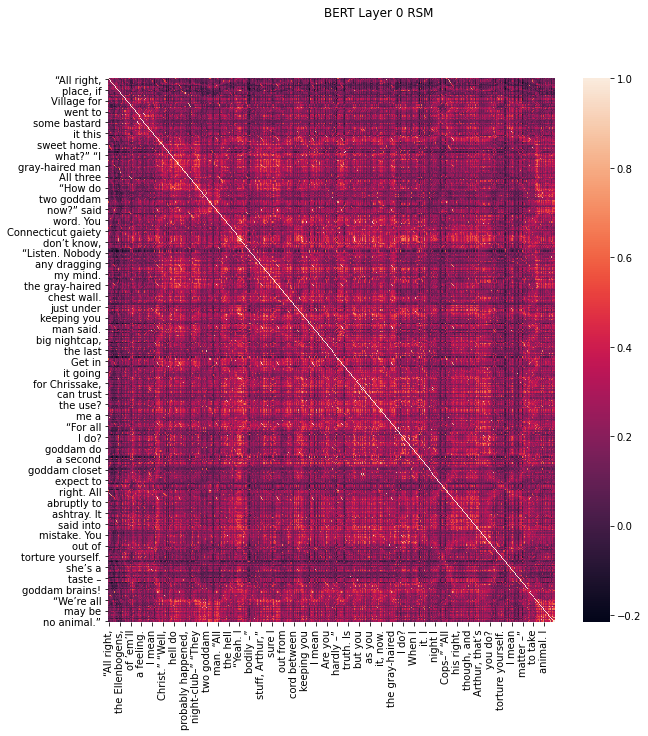

In [265]:
plt.figure(figsize=(10,10))
sns.heatmap(rsm_dfs[0])
plt.suptitle("BERT Layer 0 RSM");

Text(0.5, 0.98, 'BERT Layer 12 RSM')

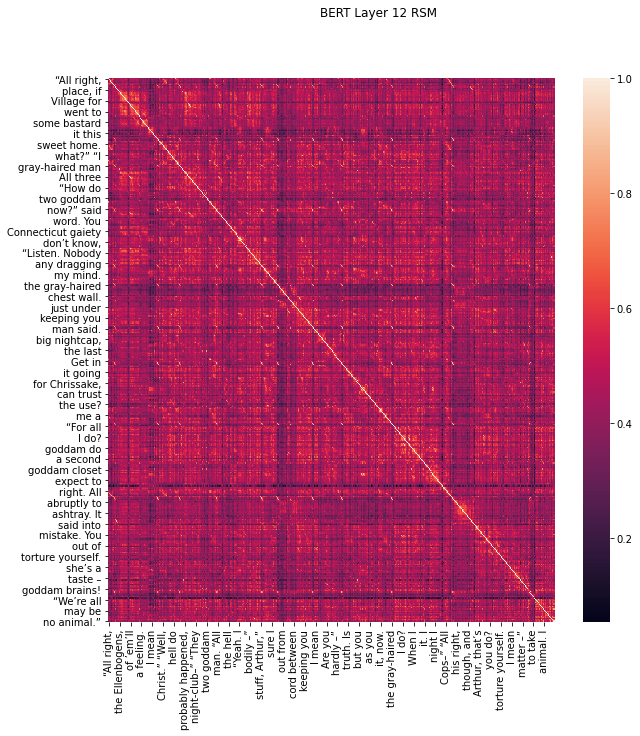

In [266]:
plt.figure(figsize=(10,10))
sns.heatmap(rsm_dfs[-1])
plt.suptitle("BERT Layer 12 RSM");